In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ift6758.training import AdvancedModel
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

In [3]:
train_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

In [11]:
modelsDict = {
    'xgboost_distance-angle': AdvancedModel(pickle.load(open('../../train/xgboost_distance-angle/model.pkl', 'rb'))).get_pred_proba(X_val[['distance_goal', 'angle_shot']])
}

/Users/JJKaufman/DESS/IFT6758/ift6758-venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/JJKaufman/DESS/IFT6758/ift6758-venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/JJKaufman/DESS/IFT6758/ift6758-venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/JJKaufman/DESS/IFT6758/ift6758-venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

AttributeError: Line2D.set() got an unexpected keyword argument 'plot_chance_level'

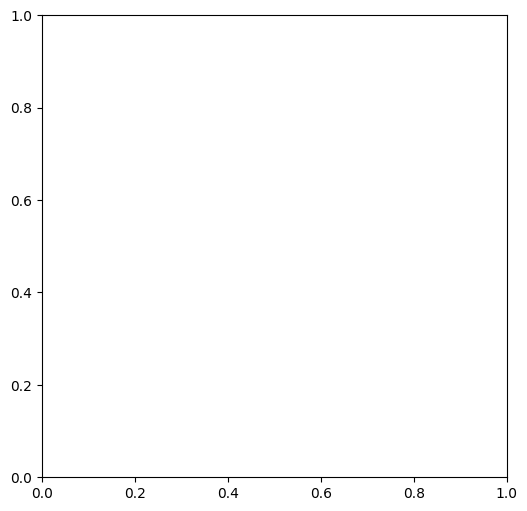

In [12]:
from ift6758.training.plot import plot_all
plot_all(modelsDict, y_val)